<center><img src="http://sydney.edu.au/images/content/about/logo-mono.jpg"></center>

<center><h1>Statistical Learning and Data Mining (QBUS6810)</h1></center>
<center><h2>Tutorial 12: Tree-Based Methods for Regression</h2></center>
<br>

<a class="buttom" href=">#Data:-California-Housing">Data: California Housing</a> <br>
<a class="buttom" href="#Exploratory-data-analysis">Exploratory data analysis</a> <br>
<a class="buttom" href="#Regression-tree">Regression Tree</a> <br>
<a class="buttom" href="#Bagging-and-random-forests">Bagging and random forests</a> <br>
<a class="buttom" href="#Linear-and-generalised-additive-models">Linear and generalised additive models</a> <br>
<a class="buttom" href="#Model-evaluation">Model Evaluation</a> <br>
<a class="buttom" href="#Model-stacking">Model stacking</a> <br>

This notebook relies on the following libraries and settings.

In [1]:
# Packages
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
colors = ['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8C564B', '#E377C2','#7F7F7F', '#BCBD22', '#17BECF']
muted = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colors)
%matplotlib inline

In [3]:
# Methods
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV, RidgeCV
from patsy import dmatrix, build_design_matrices
from statlearning import GAM_splines, rmse_jack, r2_jack, mae

##Data: California Housing

We use the California housing dataset, which we can obtain directly from the scikit-learn distribution. 

In [4]:
from sklearn.datasets.california_housing import fetch_california_housing
raw = fetch_california_housing()
print(raw.DESCR)

California housing dataset.

The original database is available from StatLib

    http://lib.stat.cmu.edu/datasets/

The data contains 20,640 observations on 9 variables.

This dataset contains the average house value as target variable
and the following input variables (features): average income,
housing average age, average rooms, average bedrooms, population,
average occupation, latitude, and longitude in that order.

References
----------

Pace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions,
Statistics and Probability Letters, 33 (1997) 291-297.




I prefer to work with pandas, so that the next cells stores the dataset in a dataframe. 

In [5]:
data = pd.DataFrame(raw.data, columns=raw.feature_names)
data['MedianHouseValue']=raw.target
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


Some of the predictors have severe outliers, which we remove as follows for simplicity. 

In [6]:
data=data[data['AveRooms']<data['AveRooms'].quantile(.99)]
data=data[data['Population']<data['Population'].quantile(.99)]
data=data[data['AveOccup']<data['AveOccup'].quantile(.99)]

Next, we identify the variables and split the data into training and test samples.

(a) The training set is only a small fraction of the data. This is to reduce the running times in the tutorial, since the original dataset is large (20,640 observations) and methods such as random forests and boosting are relatively computationally intensitive.<br/>

(b) The response is very right skewed, so that we apply the log transformation to it.<br/>

(c) We do not standardise the predictors for the tree-based methods.<br/>

In [7]:
response = data.columns[-1]
predictors= list(data.columns[:-1])
    
train = data.sample(frac=0.2, random_state=1)
test = data[data.index.isin(train.index)==False].copy()

y_train = np.log(train[response])
y_test = np.log(test[response])
X_train = train[predictors]
X_test = test[predictors]

X_train_tree = X_train.copy()
X_test_tree = X_test.copy()

mu=X_train.mean()
sigma=X_train.std()

X_train=(X_train-mu)/sigma
X_test=(X_test-mu)/sigma

##Exploratory data analysis

A key feature of this dataset is the presence of geographical information. The next cell draws a map to allow us to visualise the relationship between location and median house prices.  Warmer colours indicate higher prices, while the size of the bubbles indicates the population of the area.  

The house prices are higher near the coast, around the Bay area, and around Los Angeles.  As we will see, the geographical patterns will be crucial for predictive accurarcy. 

Note the following technical details:

(a) You need to install the basemap package to run the cell and render the map, with additional installation required for the full resolution option (you can remove it).<br/>

(b) The cell will take nearly a minute to run because of the full resolution option. <br/>

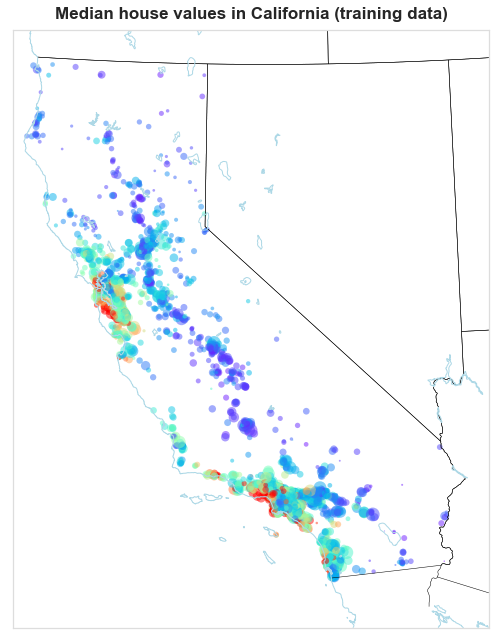

In [8]:
from mpl_toolkits.basemap import Basemap

def california_map(ax=None, lllat=31.5, urlat=42.5,
                   lllon=-124,urlon=-113):
# This function is from "Data Analytics Using Open-Source Tools" by Jeffrey Strickland
    
    m = Basemap(ax=ax, projection='stere',
                lon_0=(urlon + lllon) / 2,
                lat_0=(urlat + lllat) / 2,
                llcrnrlat=lllat, urcrnrlat=urlat,
                llcrnrlon=lllon, urcrnrlon=urlon, resolution='f')
    m.drawstates()
    m.drawcountries()
    m.drawcoastlines(color='lightblue')
    return m


fig, ax = plt.subplots(figsize=(9,9))
m = california_map()
x, y = m(train['Longitude'].as_matrix(), train['Latitude'].as_matrix())

cmap = sns.diverging_palette(220, 10, as_cmap=True)
m.scatter(x,y,s=train['Population']/30, c=train['MedianHouseValue'], edgecolors='none', cmap=plt.get_cmap('rainbow'),
         alpha=0.5)

ax.set_title('Median house values in California (training data)', fontsize=17, y=1.01, fontweight='bold')
ax.spines['bottom'].set_color('#DDDDDD')
ax.spines['top'].set_color('#DDDDDD')
ax.spines['right'].set_color('#DDDDDD')
ax.spines['left'].set_color('#DDDDDD')

plt.tight_layout()
plt.show()

The two variables with strogest linear relationship with house values are the median income of the area, and the average number of rooms. Further exploration through the scatter plots below reveal nonlinear patterns for the median income, average rooms, and average occupancy. Population, housing average age, and average bedrooms seem to have only weak relationships with house values. 

In [9]:
train.corr().round(3)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
MedInc,1.000,-0.131,0.674,-0.179,-0.001,-0.068,-0.069,-0.029,0.697
HouseAge,-0.131,1.000,-0.203,-0.092,-0.305,-0.009,0.013,-0.099,0.085
AveRooms,0.674,-0.203,1.000,0.237,-0.071,-0.018,0.114,-0.079,0.341
AveBedrms,-0.179,-0.092,0.237,1.000,-0.027,-0.116,0.050,0.012,-0.071
Population,-0.001,-0.305,-0.071,-0.027,1.000,0.189,-0.125,0.106,-0.019
AveOccup,-0.068,-0.009,-0.018,-0.116,0.189,1.000,-0.169,0.182,-0.282
Latitude,-0.069,0.013,0.114,0.050,-0.125,-0.169,1.000,-0.930,-0.132
Longitude,-0.029,-0.099,-0.079,0.012,0.106,0.182,-0.930,1.000,-0.054
MedianHouseValue,0.697,0.085,0.341,-0.071,-0.019,-0.282,-0.132,-0.054,1.000


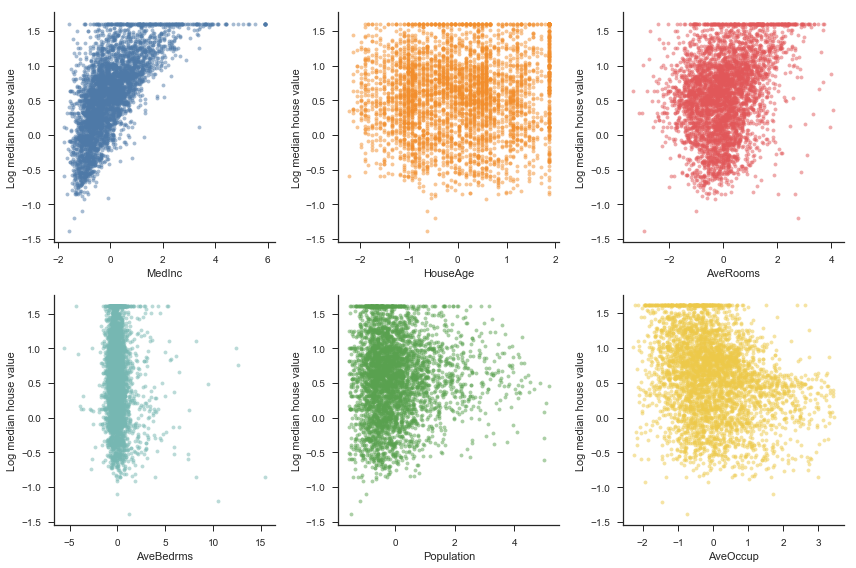

In [10]:
with sns.color_palette(muted):
    fig, axes = plt.subplots(2,3, figsize=(12,8))

    for i, ax in enumerate(fig.axes):
        sns.regplot(X_train.iloc[:,i], y_train, scatter_kws = {'s': 15, 'alpha': 0.5}, ax=ax, fit_reg=False)
        ax.set_ylabel('Log median house value')

    sns.despine()
    plt.tight_layout()
    plt.show()

##Regression tree

The basic syntax for fitting a regression tree by recursive binary splitting is the following, where we allow the tree to have a maximum depth of two for visualisation.  I also specify the minimum number of samples in the terminal nodes to highlight the importance explictly controlling this tuning parameter.

In [11]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=2, min_samples_leaf=5)
tree.fit(X_train_tree, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

To plot the decision tree, we need to use the <TT>python-graphviz</TT> package. You should experiment with letting the tree grow a few more steps and interpreting the result. 

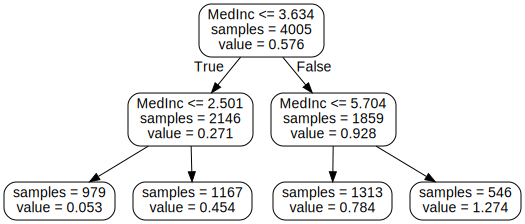

In [12]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(tree, out_file=None, feature_names=predictors, impurity=False, rounded=True) 
graph = graphviz.Source(dot_data)
# uncomment if you want to save to save the tree as a pdf file
# graph.render('tree')
graph

Next, we should find a tree of optimal size for prediction. Unfortunately, scikit-learn does not support cost-complexity pruning. As an alternative, we select the depth and minimum node size. In this tutorial, we start using the automated [<TT>GridSearchCV</TT>](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) function for this purpose. 

In [13]:
from sklearn.model_selection import GridSearchCV

In [14]:
# This cell may take half a minute to run

model = DecisionTreeRegressor(max_depth=2, min_samples_leaf=5)

tuning_parameters = [{
    'min_samples_leaf': [1,5,10,20],
    'max_depth': np.arange(1,30),
}]

# setting return_train_score=False substantially reduces the running time
tree = GridSearchCV(model, tuning_parameters, cv=10, return_train_score=False)
tree.fit(X_train_tree, y_train)
tree.best_params_

{'max_depth': 9, 'min_samples_leaf': 10}

##Bagging and random forests

The basic syntax for bagging the regression tree is as follows. Since, bagging is special case of random forests, do

In [15]:
from sklearn.ensemble import BaggingRegressor

bag = BaggingRegressor(n_estimators=1000, random_state=1)
bag.fit(X_train_tree, y_train)

BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=1000, n_jobs=1, oob_score=False, random_state=1,
         verbose=0, warm_start=False)

The next cell shows the syntax for a random forest regressor.  

In [16]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=1000, max_features ='auto', min_samples_leaf= 10)
rf.fit(X_train_tree, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Recall that the tuning parameters for a random forecast are the number of randomly selected candidate variables for each split, and the mininum node size. Unfortunately, the next cell takes a while to run (currently 3.5 minutes on my computer). Reduce the number of bootstrap samples (<TT>n_estimators</TT>) or possible values of the hyperparameters for a faster result. 

In [27]:
%%time

model = RandomForestRegressor(n_estimators=1000)

tuning_parameters = [{
    'min_samples_leaf': [1,5,10],
    'max_features': list(np.arange(2,len(predictors)+1)),
}]

# the n_jobs option enables parallel processing
rf = GridSearchCV(model, tuning_parameters, cv=10, return_train_score=False, n_jobs=4)
rf.fit(X_train_tree, y_train)

Wall time: 6min 47s


In [28]:
rf.best_params_

{'max_features': 3, 'min_samples_leaf': 1}

After selecting the hyperparameters, it is better to refit the model with a larger number of bootstrap samples. 

In [19]:
rf = RandomForestRegressor(n_estimators=5000, max_features = rf.best_params_['max_features'], 
                           min_samples_leaf= rf.best_params_['min_samples_leaf'])
rf.fit(X_train_tree, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=10,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=5000, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

We write a function to plot the variable importances in the statistical learning module. Even the median income is the most powerful predictor, we confirm that the latitude and longitude play an important roile in the random forest. 

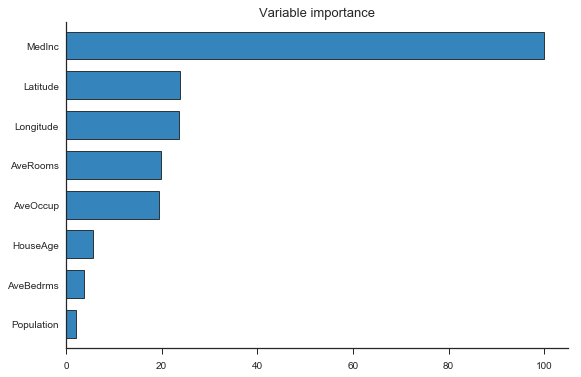

In [20]:
from statlearning import plot_feature_importance
plot_feature_importance(rf, predictors)
plt.show()

##Boosting

Boosting is one of the topics in the last week of the unit. Since this is the last tutorial on regression, we include this method without discussing the details for now. 

The next cell takes five minutes to run on my computer. Save time by setting a model based on the selected tuning parameters indicated in the following cell.

In [23]:
#%%time

from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor()

tuning_parameters = [{
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators' : [250, 500, 750, 1000, 1500],
    'max_depth' : [2,3,4,5]
}]

gb = GridSearchCV(model, tuning_parameters, cv=10, return_train_score=False, n_jobs=4)
gb.fit(X_train_tree, y_train)

Wall time: 4min 57s


In [24]:
gb.best_params_

{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 750}

##Linear and generalised additive models

For comparison, we also estimate a linear regression, the lasso, ridge regression, and a generalised additive model based on regression splines. Note that the lasso and ridge regression are not very relevant for this dataset, since the number of predictors is not a concern for this problem.  We nevertheless include these methods to highlight this point. 

We leave the latitude and longitude as predictors in these linear models to make them directly comparable with the other methods.  

In [25]:
# OLS
ols = LinearRegression()
ols.fit(X_train, y_train)

# Lasso
lasso = LassoCV(cv=5)
lasso.fit(X_train, y_train)

# Ridge
alphas = np.exp(np.linspace(-10,20,500)) 
ridge = RidgeCV(alphas=alphas, cv=5)
ridge.fit(X_train, y_train)

# Generalised additive model with regression splines
nonlinear=['MedInc', 'AveOccup', 'AveRooms', 'AveBedrms','Latitude', 'Longitude']
dfs=[4,4,4,4,10,10]

X_train_gam, X_test_gam = GAM_splines(X_train, X_test, nonlinear, dfs)

gam = LinearRegression()
gam.fit(X_train_gam, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

##Model evaluation

In [29]:
columns=['Test RMSE', 'SE', 'Test R2', 'SE', 'Test MAE', 'SE']
rows=['OLS', 'Ridge', 'Lasso', 'GAM', 'Decision tree', 'Bagged trees', 'Random forest', 'Gradient boosting']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[ols, ridge, lasso, gam, tree, bag, rf, gb]

for i, method in enumerate(methods):
    
    if i < 3:
        y_pred=method.predict(X_test)
    elif i==3:
        y_pred=method.predict(X_test_gam)
    else:
        y_pred=method.predict(X_test_tree)
    
    results.iloc[i,0], results.iloc[i,1] = rmse_jack(y_test, y_pred)
    results.iloc[i,2], results.iloc[i,3] = r2_jack(y_test, y_pred)
    results.iloc[i,4], results.iloc[i,5] = mae(y_test, y_pred)

results.round(3)

,Test RMSE,SE,Test R2,SE,Test MAE,SE
OLS,0.324,0.003,0.676,0.005,0.244,0.002
Ridge,0.324,0.003,0.676,0.005,0.244,0.002
Lasso,0.324,0.003,0.676,0.005,0.244,0.002
GAM,0.275,0.003,0.767,0.004,0.203,0.001
Decision tree,0.313,0.003,0.697,0.006,0.225,0.002
Bagged trees,0.256,0.003,0.798,0.004,0.182,0.001
Random forest,0.250,0.003,0.807,0.004,0.180,0.001
Gradient boosting,0.232,0.003,0.833,0.004,0.164,0.001
